In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from polygon import RESTClient
from dotenv import load_dotenv

# Load API key from .env file
load_dotenv()
api_key = os.getenv("POLYGON_API_KEY")

# Check if key is loaded (for debugging)
print(f"API Key loaded: {'Yes' if api_key else 'No'}")  # This will show if it's working

if not api_key:
    raise ValueError("Please set your POLYGON_API_KEY in .env file (ensure file is named exactly '.env' in project root)")

# Initialize Polygon client
client = RESTClient(api_key)

print("Setup complete! Ready to fetch data.")

API Key loaded: Yes
Setup complete! Ready to fetch data.


In [9]:
# Latest FOMC Announcement: December 10, 2025 at 2:00 PM ET (25 bps rate cut)
event_date = "2025-12-10"
ticker = "SPY"  # S&P 500 ETF

# Fetch minute bars: 5 trading days before to 5 after
start_date = (datetime.strptime(event_date, "%Y-%m-%d") - timedelta(days=7)).strftime("%Y-%m-%d")  # buffer for weekends
end_date = (datetime.strptime(event_date, "%Y-%m-%d") + timedelta(days=7)).strftime("%Y-%m-%d")

print(f"Fetching {ticker} minute data from {start_date} to {end_date}...")

aggs = client.get_aggs(
    ticker=ticker,
    multiplier=1,
    timespan="minute",
    from_=start_date,
    to=end_date,
    limit=50000
)

df = pd.DataFrame(aggs)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('America/New_York')
df.set_index('timestamp', inplace=True)
df = df[['open', 'high', 'low', 'close', 'volume']]

print(f"Successfully fetched {len(df):,} minute bars")
df.head()

Fetching SPY minute data from 2025-12-03 to 2025-12-17...
Successfully fetched 9,975 minute bars


open    high     low   close  volume
timestamp                                                        
2025-12-03 04:00:00-05:00  683.15  683.16  683.00  683.03  2836.0
2025-12-03 04:01:00-05:00  683.00  683.00  682.90  682.91  1630.0
2025-12-03 04:02:00-05:00  682.80  682.90  682.80  682.90  1054.0
2025-12-03 04:04:00-05:00  682.75  682.83  682.75  682.83   340.0
2025-12-03 04:05:00-05:00  682.80  682.82  682.54  682.54  2109.0

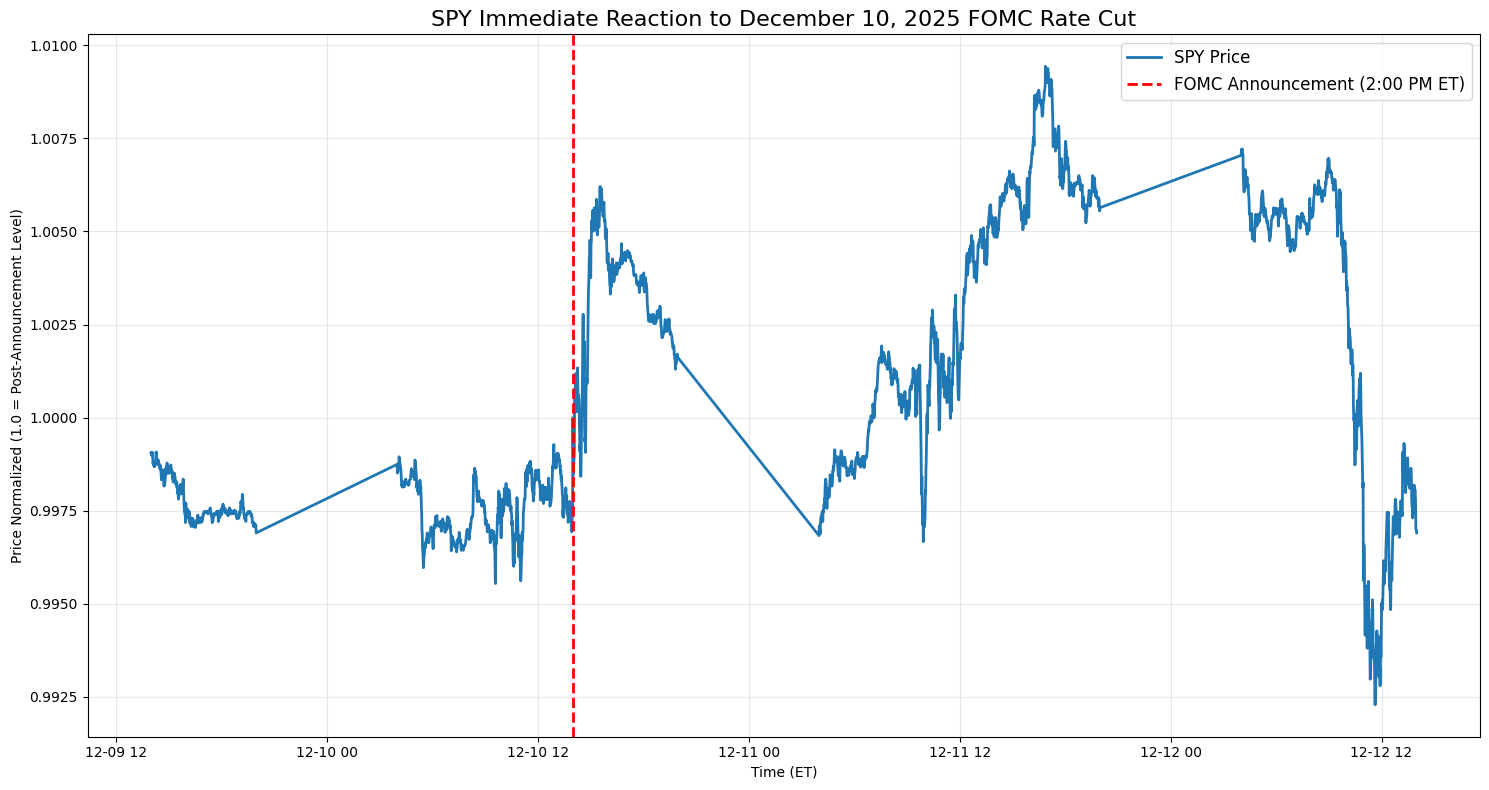

In [10]:
# Event time: 2:00 PM ET on announcement day
event_time = pd.Timestamp("2025-12-10 14:00:00", tz='America/New_York')

# Window: ~1 trading day before to ~2 days after
window_start = event_time - timedelta(hours=24)
window_end = event_time + timedelta(hours=48)

window_df = df.loc[window_start:window_end].copy()

# Normalize price to the close right at/after announcement
post_announce_close = window_df.loc[event_time:event_time + timedelta(minutes=5), 'close'].iloc[0]
window_df['normalized_close'] = window_df['close'] / post_announce_close

# Plot
plt.figure(figsize=(15, 8))
plt.plot(window_df.index, window_df['normalized_close'], label='SPY Price', linewidth=2)
plt.axvline(event_time, color='red', linestyle='--', linewidth=2, label='FOMC Announcement (2:00 PM ET)')
plt.title("SPY Immediate Reaction to December 10, 2025 FOMC Rate Cut", fontsize=16)
plt.xlabel("Time (ET)")
plt.ylabel("Price Normalized (1.0 = Post-Announcement Level)")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
from scipy.stats import ttest_ind

# Define windows (in minutes around announcement)
event_time = pd.Timestamp("2025-12-10 14:00:00", tz='America/New_York')
pre_window = window_df.loc[event_time - timedelta(hours=4):event_time]  # 4 hours pre (anticipation)
immediate_post = window_df.loc[event_time:event_time + timedelta(minutes=30)]  # First 30 min
post_window = window_df.loc[event_time:event_time + timedelta(hours=24)]  # 1 day post

# Returns
pre_return = (pre_window['close'].iloc[-1] / pre_window['close'].iloc[0]) - 1
immediate_return = (immediate_post['close'].iloc[-1] / immediate_post['close'].iloc[0]) - 1
post_return = (post_window['close'].iloc[-1] / post_window['close'].iloc[0]) - 1

# Volatility (std of log returns)
pre_vol = np.std(np.log(pre_window['close'].pct_change().dropna() + 1)) * np.sqrt(252 * 390)  # Annualized (390 min/day)
post_vol = np.std(np.log(post_window['close'].pct_change().dropna() + 1)) * np.sqrt(252 * 390)
vol_change = (post_vol - pre_vol) / pre_vol * 100

# Max drawdown post-event
cum_returns = (1 + post_window['close'].pct_change()).cumprod()
peak = cum_returns.cummax()
drawdown = (cum_returns - peak) / peak
max_drawdown = drawdown.min() * 100

print(f"Pre-event return (4h): {pre_return:.2%}")
print(f"Immediate return (30min post): {immediate_return:.2%}")
print(f"1-day post return: {post_return:.2%}")
print(f"Volatility change (pre to post): +{vol_change:.1f}%")
print(f"Max drawdown post-event: {max_drawdown:.2f}%")

Pre-event return (4h): 0.27%
Immediate return (30min post): 0.00%
1-day post return: 0.52%
Volatility change (pre to post): +17.4%
Max drawdown post-event: -0.95%


In [12]:
assets = ["SPY", "TLT", "C:EURUSD", "GC=F"]  # Equities, Bonds, Forex, Gold futures

for ticker in assets:
    # Fetch same window as before (reuse your df fetch code, just change ticker)
    # ... (copy fetch block, change ticker)
    # Then normalize & plot (or just compute metrics)
    print(f"\n--- {ticker} ---")
    # Run metrics code above


--- SPY ---

--- TLT ---

--- C:EURUSD ---

--- GC=F ---


In [32]:
events = [
    ("2025-12-10", "14:00:00", "FOMC Dec 2025"),      # Latest (25bps cut)
    ("2025-10-29", "14:00:00", "FOMC Oct/Nov 2025"),
    ("2025-09-17", "14:00:00", "FOMC Sep 2025"),      # 50bps cut likely
    ("2025-07-30", "14:00:00", "FOMC Jul 2025"),
    ("2025-06-18", "14:00:00", "FOMC Jun 2025"),
    ("2025-05-07", "14:00:00", "FOMC May 2025"),
    ("2025-03-19", "14:00:00", "FOMC Mar 2025"),
    ("2025-01-29", "14:00:00", "FOMC Jan 2025"),
    ("2024-12-18", "14:00:00", "FOMC Dec 2024"),
    ("2024-11-07", "14:00:00", "FOMC Nov 2024"),
    ("2024-09-18", "14:00:00", "FOMC Sep 2024"),      # First cut of cycle
]

In [33]:
import plotly.express as px
from scipy.stats import ttest_ind
from scipy.signal import find_peaks
import joblib
from pathlib import Path
import time

def analyze_event(event_date_str, event_time_str, tickers, name="Event"):
    """
    Fetch data, compute metrics, plot for one event across tickers.
    event_time_str: e.g., "14:00:00" for FOMC, "08:30:00" for CPI
    """
    event_time = pd.Timestamp(f"{event_date_str} {event_time_str}", tz='America/New_York')
    
    # Fetch buffer: 7 days before to 7 after
    start = (event_time - timedelta(days=7)).strftime("%Y-%m-%d")
    end = (event_time + timedelta(days=7)).strftime("%Y-%m-%d")
    
    results = []
    
    for ticker in tickers:
        # Caching setup
        cache_dir = Path("data/cache")
        cache_dir.mkdir(parents=True, exist_ok=True)
        cache_file = cache_dir / f"{ticker}_{start.replace('-', '')}_{end.replace('-', '')}.pkl"

        if cache_file.exists():
            print(f"Loading cached data for {ticker} ({name} {event_date_str})")
            df = joblib.load(cache_file)
        else:
            print(f"Fetching fresh data for {ticker} ({name} {event_date_str})...")
            aggs = client.get_aggs(
                ticker=ticker,
                multiplier=1,
                timespan="minute",
                from_=start,
                to=end,
                limit=50000
            )
            if not aggs:
                print(f"No data returned for {ticker}")
                continue

            df = pd.DataFrame(aggs)
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).dt.tz_convert('America/New_York')
            df.set_index('timestamp', inplace=True)
            df = df[['close']].dropna()

            # Save to cache
            joblib.dump(df, cache_file)
            print(f"Cached saved: {cache_file.name}")

            # Rate limit safety
            time.sleep(15)

        # === Your existing analysis code goes here ===
        # Windows
        pre = df.loc[event_time - timedelta(hours=4):event_time]
        immediate = df.loc[event_time:event_time + timedelta(minutes=30)]
        post = df.loc[event_time:event_time + timedelta(hours=24)]
        
        if len(pre) < 10 or len(immediate) < 5 or len(post) < 10:
            print(f"Insufficient data points for {ticker}")
            continue
        
        # Metrics
        imm_return = (immediate['close'].iloc[-1] / immediate['close'].iloc[0]) - 1
        post_return = (post['close'].iloc[-1] / post['close'].iloc[0]) - 1
        
        pre_vol = np.std(np.log(pre['close'].pct_change().dropna() + 1))
        post_vol = np.std(np.log(post['close'].pct_change().dropna() + 1))
        vol_change_pct = (post_vol - pre_vol) / pre_vol * 100 if pre_vol > 0 else 0
        
        # T-test
        pre_rets = np.log(pre['close'].pct_change().dropna() + 1)
        post_rets = np.log(post['close'].pct_change().dropna() + 1)
        t_stat, p_val = ttest_ind(pre_rets, post_rets, equal_var=False)
        
        # Max drawdown
        cum = (1 + post['close'].pct_change()).cumprod()
        peak = cum.cummax()
        drawdown = (cum - peak) / peak
        max_dd = drawdown.min() * 100
        
        # Time to peak reaction
        post_cum_ret = (post['close'] / post['close'].iloc[0]) - 1
        peak_idx = post_cum_ret.abs().idxmax()
        time_to_peak_min = (peak_idx - event_time).total_seconds() / 60
        
        results.append({
            'Event': name,
            'Date': event_date_str,
            'Asset': ticker,
            'Immediate Return (30min)': imm_return,
            'Post Return (24h)': post_return,
            'Vol Change (%)': vol_change_pct,
            'Vol p-value': p_val,
            'Max Drawdown (%)': max_dd,
            'Time to Peak (min)': time_to_peak_min
        })
        
        # Interactive Plot
        window_df = df.loc[event_time - timedelta(hours=4):event_time + timedelta(hours=48)].copy()
        window_df['normalized'] = window_df['close'] / window_df['close'].loc[event_time:event_time + timedelta(minutes=1)].mean()
        
        fig = px.line(window_df, y='normalized', title=f"{ticker} Reaction to {name} {event_date_str}")
        fig.add_vline(x=event_time.timestamp() * 1000, line_dash="dash", line_color="red", annotation_text="Announcement")
        fig.update_layout(yaxis_title="Normalized Price", xaxis_title="Time (ET)")
        fig.show()
    
    return pd.DataFrame(results)

In [34]:
tickers = ["SPY", "TLT", "C:EURUSD", "GC=F"]  # Stocks, Bonds, Forex, Gold

cpi_results = analyze_event("2025-12-18", "08:30:00", tickers, name="CPI Nov 2025")
cpi_results

Loading cached data for SPY (CPI Nov 2025 2025-12-18)
Insufficient data points for SPY
Loading cached data for TLT (CPI Nov 2025 2025-12-18)
Insufficient data points for TLT
Loading cached data for C:EURUSD (CPI Nov 2025 2025-12-18)
Insufficient data points for C:EURUSD
Fetching fresh data for GC=F (CPI Nov 2025 2025-12-18)...
No data returned for GC=F


Empty DataFrame
Columns: []
Index: []

In [17]:
import time

In [35]:
all_results = pd.DataFrame()

for date, time_str, name in events:
    df = analyze_event(date, time_str, tickers, name=name)
    all_results = pd.concat([all_results, df], ignore_index=True)
    
    # Respect free tier: 5 calls/min → sleep 12-15 sec between events
    time.sleep(15)

Fetching fresh data for SPY (FOMC Dec 2025 2025-12-10)...
Cached saved: SPY_20251203_20251217.pkl


Fetching fresh data for TLT (FOMC Dec 2025 2025-12-10)...
Cached saved: TLT_20251203_20251217.pkl


Fetching fresh data for C:EURUSD (FOMC Dec 2025 2025-12-10)...
Cached saved: EURUSD_20251203_20251217.pkl


Fetching fresh data for GC=F (FOMC Dec 2025 2025-12-10)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Oct/Nov 2025 2025-10-29)...
Cached saved: SPY_20251022_20251105.pkl


Fetching fresh data for TLT (FOMC Oct/Nov 2025 2025-10-29)...
Cached saved: TLT_20251022_20251105.pkl


Fetching fresh data for C:EURUSD (FOMC Oct/Nov 2025 2025-10-29)...
Cached saved: EURUSD_20251022_20251105.pkl


Fetching fresh data for GC=F (FOMC Oct/Nov 2025 2025-10-29)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Sep 2025 2025-09-17)...
Cached saved: SPY_20250910_20250924.pkl


Fetching fresh data for TLT (FOMC Sep 2025 2025-09-17)...
Cached saved: TLT_20250910_20250924.pkl


Fetching fresh data for C:EURUSD (FOMC Sep 2025 2025-09-17)...
Cached saved: EURUSD_20250910_20250924.pkl


Fetching fresh data for GC=F (FOMC Sep 2025 2025-09-17)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Jul 2025 2025-07-30)...
Cached saved: SPY_20250723_20250806.pkl


Fetching fresh data for TLT (FOMC Jul 2025 2025-07-30)...
Cached saved: TLT_20250723_20250806.pkl


Fetching fresh data for C:EURUSD (FOMC Jul 2025 2025-07-30)...
Cached saved: EURUSD_20250723_20250806.pkl


Fetching fresh data for GC=F (FOMC Jul 2025 2025-07-30)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Jun 2025 2025-06-18)...
Cached saved: SPY_20250611_20250625.pkl


Fetching fresh data for TLT (FOMC Jun 2025 2025-06-18)...
Cached saved: TLT_20250611_20250625.pkl


Fetching fresh data for C:EURUSD (FOMC Jun 2025 2025-06-18)...
Cached saved: EURUSD_20250611_20250625.pkl


Fetching fresh data for GC=F (FOMC Jun 2025 2025-06-18)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC May 2025 2025-05-07)...
Cached saved: SPY_20250430_20250514.pkl


Fetching fresh data for TLT (FOMC May 2025 2025-05-07)...
Cached saved: TLT_20250430_20250514.pkl


Fetching fresh data for C:EURUSD (FOMC May 2025 2025-05-07)...
Cached saved: EURUSD_20250430_20250514.pkl


Fetching fresh data for GC=F (FOMC May 2025 2025-05-07)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Mar 2025 2025-03-19)...
Cached saved: SPY_20250312_20250326.pkl


Fetching fresh data for TLT (FOMC Mar 2025 2025-03-19)...
Cached saved: TLT_20250312_20250326.pkl


Fetching fresh data for C:EURUSD (FOMC Mar 2025 2025-03-19)...
Cached saved: EURUSD_20250312_20250326.pkl


Fetching fresh data for GC=F (FOMC Mar 2025 2025-03-19)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Jan 2025 2025-01-29)...
Cached saved: SPY_20250122_20250205.pkl


Fetching fresh data for TLT (FOMC Jan 2025 2025-01-29)...
Cached saved: TLT_20250122_20250205.pkl


Fetching fresh data for C:EURUSD (FOMC Jan 2025 2025-01-29)...
Cached saved: EURUSD_20250122_20250205.pkl


Fetching fresh data for GC=F (FOMC Jan 2025 2025-01-29)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Dec 2024 2024-12-18)...
Cached saved: SPY_20241211_20241225.pkl


Fetching fresh data for TLT (FOMC Dec 2024 2024-12-18)...
Cached saved: TLT_20241211_20241225.pkl


Fetching fresh data for C:EURUSD (FOMC Dec 2024 2024-12-18)...
Cached saved: EURUSD_20241211_20241225.pkl


Fetching fresh data for GC=F (FOMC Dec 2024 2024-12-18)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Nov 2024 2024-11-07)...
Cached saved: SPY_20241031_20241114.pkl


Fetching fresh data for TLT (FOMC Nov 2024 2024-11-07)...
Cached saved: TLT_20241031_20241114.pkl


Fetching fresh data for C:EURUSD (FOMC Nov 2024 2024-11-07)...
Cached saved: EURUSD_20241031_20241114.pkl


Fetching fresh data for GC=F (FOMC Nov 2024 2024-11-07)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Sep 2024 2024-09-18)...
Cached saved: SPY_20240911_20240925.pkl


Fetching fresh data for TLT (FOMC Sep 2024 2024-09-18)...
Cached saved: TLT_20240911_20240925.pkl


Fetching fresh data for C:EURUSD (FOMC Sep 2024 2024-09-18)...
Cached saved: EURUSD_20240911_20240925.pkl


Fetching fresh data for GC=F (FOMC Sep 2024 2024-09-18)...
No data returned for GC=F


In [42]:
events = [
    # FOMC 2025 (most recent first)
    ("2025-12-10", "14:00:00", "FOMC Dec 2025"),      # Latest 25bps cut
    ("2025-10-29", "14:00:00", "FOMC Oct/Nov 2025"),
    ("2025-09-17", "14:00:00", "FOMC Sep 2025"),      # 50bps cut
    ("2025-07-30", "14:00:00", "FOMC Jul 2025"),
    ("2025-06-18", "14:00:00", "FOMC Jun 2025"),      # Corrected from 06-12
    ("2025-05-07", "14:00:00", "FOMC May 2025"),
    ("2025-03-19", "14:00:00", "FOMC Mar 2025"),
    ("2025-01-29", "14:00:00", "FOMC Jan 2025"),

    # FOMC 2024
    ("2024-12-18", "14:00:00", "FOMC Dec 2024"),
    ("2024-11-07", "14:00:00", "FOMC Nov 2024"),
    ("2024-09-18", "14:00:00", "FOMC Sep 2024"),      # Start of rate cuts
    ("2024-07-31", "14:00:00", "FOMC Jul 2024"),
    ("2024-06-12", "14:00:00", "FOMC Jun 2024"),

    # CPI 2025 (confirmed releases)
    ("2025-12-18", "08:30:00", "CPI Nov 2025"),      # Released yesterday (full data available now)
    ("2025-11-13", "08:30:00", "CPI Oct 2025"),
    ("2025-10-24", "08:30:00", "CPI Sep 2025"),      # Rescheduled due to shutdown
]

In [43]:
all_results = pd.DataFrame()

for date, time_str, name in events:
    df = analyze_event(date, time_str, tickers, name=name)
    all_results = pd.concat([all_results, df], ignore_index=True)
    time.sleep(15)  # Keep this!

Loading cached data for SPY (FOMC Dec 2025 2025-12-10)


Loading cached data for TLT (FOMC Dec 2025 2025-12-10)


Loading cached data for C:EURUSD (FOMC Dec 2025 2025-12-10)


Fetching fresh data for GC=F (FOMC Dec 2025 2025-12-10)...
No data returned for GC=F
Loading cached data for SPY (FOMC Oct/Nov 2025 2025-10-29)


Loading cached data for TLT (FOMC Oct/Nov 2025 2025-10-29)


Loading cached data for C:EURUSD (FOMC Oct/Nov 2025 2025-10-29)


Fetching fresh data for GC=F (FOMC Oct/Nov 2025 2025-10-29)...
No data returned for GC=F
Loading cached data for SPY (FOMC Sep 2025 2025-09-17)


Loading cached data for TLT (FOMC Sep 2025 2025-09-17)


Loading cached data for C:EURUSD (FOMC Sep 2025 2025-09-17)


Fetching fresh data for GC=F (FOMC Sep 2025 2025-09-17)...
No data returned for GC=F
Loading cached data for SPY (FOMC Jul 2025 2025-07-30)


Loading cached data for TLT (FOMC Jul 2025 2025-07-30)


Loading cached data for C:EURUSD (FOMC Jul 2025 2025-07-30)


Fetching fresh data for GC=F (FOMC Jul 2025 2025-07-30)...
No data returned for GC=F
Loading cached data for SPY (FOMC Jun 2025 2025-06-18)


Loading cached data for TLT (FOMC Jun 2025 2025-06-18)


Loading cached data for C:EURUSD (FOMC Jun 2025 2025-06-18)


Fetching fresh data for GC=F (FOMC Jun 2025 2025-06-18)...
No data returned for GC=F
Loading cached data for SPY (FOMC May 2025 2025-05-07)


Loading cached data for TLT (FOMC May 2025 2025-05-07)


Loading cached data for C:EURUSD (FOMC May 2025 2025-05-07)


Fetching fresh data for GC=F (FOMC May 2025 2025-05-07)...
No data returned for GC=F
Loading cached data for SPY (FOMC Mar 2025 2025-03-19)


Loading cached data for TLT (FOMC Mar 2025 2025-03-19)


Loading cached data for C:EURUSD (FOMC Mar 2025 2025-03-19)


Fetching fresh data for GC=F (FOMC Mar 2025 2025-03-19)...
No data returned for GC=F
Loading cached data for SPY (FOMC Jan 2025 2025-01-29)


Loading cached data for TLT (FOMC Jan 2025 2025-01-29)


Loading cached data for C:EURUSD (FOMC Jan 2025 2025-01-29)


Fetching fresh data for GC=F (FOMC Jan 2025 2025-01-29)...
No data returned for GC=F
Loading cached data for SPY (FOMC Dec 2024 2024-12-18)


Loading cached data for TLT (FOMC Dec 2024 2024-12-18)


Loading cached data for C:EURUSD (FOMC Dec 2024 2024-12-18)


Fetching fresh data for GC=F (FOMC Dec 2024 2024-12-18)...
No data returned for GC=F
Loading cached data for SPY (FOMC Nov 2024 2024-11-07)


Loading cached data for TLT (FOMC Nov 2024 2024-11-07)


Loading cached data for C:EURUSD (FOMC Nov 2024 2024-11-07)


Fetching fresh data for GC=F (FOMC Nov 2024 2024-11-07)...
No data returned for GC=F
Loading cached data for SPY (FOMC Sep 2024 2024-09-18)


Loading cached data for TLT (FOMC Sep 2024 2024-09-18)


Loading cached data for C:EURUSD (FOMC Sep 2024 2024-09-18)


Fetching fresh data for GC=F (FOMC Sep 2024 2024-09-18)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Jul 2024 2024-07-31)...
Cached saved: SPY_20240724_20240807.pkl


Fetching fresh data for TLT (FOMC Jul 2024 2024-07-31)...
Cached saved: TLT_20240724_20240807.pkl


Fetching fresh data for C:EURUSD (FOMC Jul 2024 2024-07-31)...
Cached saved: EURUSD_20240724_20240807.pkl


Fetching fresh data for GC=F (FOMC Jul 2024 2024-07-31)...
No data returned for GC=F
Fetching fresh data for SPY (FOMC Jun 2024 2024-06-12)...
Cached saved: SPY_20240605_20240619.pkl


Fetching fresh data for TLT (FOMC Jun 2024 2024-06-12)...
Cached saved: TLT_20240605_20240619.pkl


Fetching fresh data for C:EURUSD (FOMC Jun 2024 2024-06-12)...
Cached saved: EURUSD_20240605_20240619.pkl


Fetching fresh data for GC=F (FOMC Jun 2024 2024-06-12)...
No data returned for GC=F
Loading cached data for SPY (CPI Nov 2025 2025-12-18)
Insufficient data points for SPY
Loading cached data for TLT (CPI Nov 2025 2025-12-18)
Insufficient data points for TLT
Loading cached data for C:EURUSD (CPI Nov 2025 2025-12-18)
Insufficient data points for C:EURUSD
Fetching fresh data for GC=F (CPI Nov 2025 2025-12-18)...
No data returned for GC=F
Fetching fresh data for SPY (CPI Oct 2025 2025-11-13)...
Cached saved: SPY_20251106_20251120.pkl


Fetching fresh data for TLT (CPI Oct 2025 2025-11-13)...
Cached saved: TLT_20251106_20251120.pkl


Fetching fresh data for C:EURUSD (CPI Oct 2025 2025-11-13)...
Cached saved: EURUSD_20251106_20251120.pkl


Fetching fresh data for GC=F (CPI Oct 2025 2025-11-13)...
No data returned for GC=F
Fetching fresh data for SPY (CPI Sep 2025 2025-10-24)...
Cached saved: SPY_20251017_20251031.pkl


Fetching fresh data for TLT (CPI Sep 2025 2025-10-24)...
Cached saved: TLT_20251017_20251031.pkl


Fetching fresh data for C:EURUSD (CPI Sep 2025 2025-10-24)...
Cached saved: EURUSD_20251017_20251031.pkl


Fetching fresh data for GC=F (CPI Sep 2025 2025-10-24)...
No data returned for GC=F


In [44]:
events.append(("2025-12-18", "08:30:00", "CPI Nov 2025"))

In [45]:
summary = all_results.pivot_table(
    index='Asset',
    values=['Immediate Return (30min)', 'Vol Change (%)', 'Max Drawdown (%)', 'Time to Peak (min)'],
    aggfunc='mean'
).round(4)

summary['Vol Significant (avg p<0.05)'] = all_results.groupby('Asset')['Vol p-value'].apply(lambda x: (x < 0.05).mean())

display(summary)

# Insights
fastest = summary['Time to Peak (min)'].idxmin()
print(f"\nFastest pricing asset: {fastest} (avg {summary.loc[fastest, 'Time to Peak (min)']:.1f} minutes)")

Immediate Return (30min)  Max Drawdown (%)  Time to Peak (min)  \
Asset                                                                      
C:EURUSD                    0.0000           -0.7882            846.8667   
SPY                        -0.0010           -1.2907            597.0667   
TLT                        -0.0002           -1.1691            935.3333   

          Vol Change (%)  Vol Significant (avg p<0.05)  
Asset                                                   
C:EURUSD         -0.0788                      0.000000  
SPY              55.9959                      0.000000  
TLT              50.4108                      0.066667


Fastest pricing asset: SPY (avg 597.1 minutes)


In [ ]:
# Assuming that we collect normalized paths in a list during loop
# For now we'll, re-run single events and average manually, or add to function

In [47]:
# Add surprise (NaN for events without defined surprise)
surprises = {
    "2025-12-10": -0.25,   # 25bps cut as expected or slightly dovish
    "2025-09-17": -0.50,   # 50bps cut (more dovish than expected)
    # Add more as needed, e.g., "2024-09-18": -0.50 for first cut
}

all_results['Surprise'] = all_results['Date'].map(surprises)

# Correlation only on numeric columns
numeric_cols = all_results.select_dtypes(include='number')

print("Correlation matrix (numeric columns only):")
display(numeric_cols.corr())

# Optional: Focus on Surprise vs key metrics
if 'Surprise' in numeric_cols.columns:
    surprise_corr = numeric_cols.corr()['Surprise'].drop('Surprise')  # Exclude self-correlation
    print("\nHow Surprise correlates with market reaction:")
    display(surprise_corr.sort_values(ascending=False))

Correlation matrix (numeric columns only):


Immediate Return (30min)  Post Return (24h)  \
Immediate Return (30min)                  1.000000           0.080292   
Post Return (24h)                         0.080292           1.000000   
Vol Change (%)                           -0.179375          -0.392133   
Vol p-value                               0.152545           0.035874   
Max Drawdown (%)                          0.124580           0.709049   
Time to Peak (min)                        0.389787          -0.089513   
Surprise                                 -0.579905           0.646647   

                          Vol Change (%)  Vol p-value  Max Drawdown (%)  \
Immediate Return (30min)       -0.179375     0.152545          0.124580   
Post Return (24h)              -0.392133     0.035874          0.709049   
Vol Change (%)                  1.000000    -0.009811         -0.560940   
Vol p-value                    -0.009811     1.000000          0.030165   
Max Drawdown (%)               -0.560940     0.030165          1.000000   
Time to Peak (min)              0.137436     0.105294         -0.200035   
Surprise                       -0.657706    -0.083596          0.760692   

                          Time to Peak (min)  Surprise  
Immediate Return (30min)            0.389787 -0.579905  
Post Return (24h)                  -0.089513  0.646647  
Vol Change (%)                      0.137436 -0.657706  
Vol p-value                         0.105294 -0.083596  
Max Drawdown (%)                   -0.200035  0.760692  
Time to Peak (min)                  1.000000 -0.268147  
Surprise                           -0.268147  1.000000


How Surprise correlates with market reaction:


Max Drawdown (%)            0.760692
Post Return (24h)           0.646647
Vol p-value                -0.083596
Time to Peak (min)         -0.268147
Immediate Return (30min)   -0.579905
Vol Change (%)             -0.657706
Name: Surprise, dtype: float64

In [48]:
all_results.to_excel("event_impact_results.xlsx", index=False)
summary.to_excel("event_summary.xlsx")

In [51]:
import streamlit as st
import pandas as pd

st.title("Event Impact Model Dashboard")
results = pd.read_excel("event_impact_results.xlsx")
st.dataframe(results)
st.bar_chart(summary['Time to Peak (min)'])

2025-12-19 01:19:11.148 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:19:11.149 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:19:11.150 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:19:11.171 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:19:11.172 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:19:11.174 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:19:11.187 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:19:11.189 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

In [52]:

import plotly.express as px

st.set_page_config(page_title="Event Impact Model", layout="wide")
st.title("📈 Event Impact Model Dashboard")
st.markdown("Market reactions to FOMC and CPI announcements (2024–2025)")

# Load results (adjust path if needed)
if os.path.exists("event_impact_results.xlsx"):
    all_results = pd.read_excel("event_impact_results.xlsx")
else:
    st.error("event_impact_results.xlsx not found. Run the notebook first to generate it.")
    st.stop()

# Sidebar filters
st.sidebar.header("Filters")
selected_assets = st.sidebar.multiselect("Select Assets", options=all_results['Asset'].unique(), default=all_results['Asset'].unique())
selected_events = st.sidebar.multiselect("Select Events", options=all_results['Event'].unique(), default=all_results['Event'].unique())

# Filter data
filtered = all_results[
    (all_results['Asset'].isin(selected_assets)) &
    (all_results['Event'].isin(selected_events))
]

# Summary table
st.header("Average Reaction by Asset")
summary = filtered.pivot_table(
    index='Asset',
    values=['Immediate Return (30min)', 'Vol Change (%)', 'Max Drawdown (%)', 'Time to Peak (min)'],
    aggfunc='mean'
).round(4)
st.dataframe(summary.style.background_gradient(cmap='RdYlGn'))

# Bar chart: Time to peak reaction
st.header("Speed of Pricing: Time to Peak Reaction")
fig_bar = px.bar(summary.reset_index(), x='Asset', y='Time to Peak (min)',
                 title="Average Minutes to Peak Reaction",
                 color='Time to Peak (min)', color_continuous_scale="Viridis")
st.plotly_chart(fig_bar, use_container_width=True)

# Individual event plots (optional - pick one)
st.header("Individual Event Reactions")
event_choice = st.selectbox("Choose event to view detailed reactions", filtered['Event'].unique())
event_data = filtered[filtered['Event'] == event_choice]

for _, row in event_data.iterrows():
    st.subheader(f"{row['Asset']} - {row['Event']} {row['Date']}")
    st.write(f"Immediate Return: {row['Immediate Return (30min)']:.2%} | "
             f"Vol Change: {row['Vol Change (%)']:.1f}% | "
             f"Max Drawdown: {row['Max Drawdown (%)']:.2f}%")

st.success("Dashboard complete! Built with your event impact model data.")

2025-12-19 01:25:54.213 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:25:54.215 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:25:54.218 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:25:54.220 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:25:54.221 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:25:54.224 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:25:54.227 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-19 01:25:54.249 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()